In [52]:
%load_ext autoreload
%autoreload 2

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Self imports
from eclipses import *
from src import *
from plotting import *
from cpop import *
import nfft

In [11]:
from utils.set_dir_to_root import set_dir_to_root

# Getting the Curve
set_dir_to_root()
with open("data/all_systems.txt") as f:
    all_systems = f.read().split(",")
eclipses = get_eclipses(all_systems[21], "data/combined")  #kplr006545018.fits
#eclipses = eclipses.round({"delta":3})
eclipses.head()

,time,duration,delta
0,1.000000,0.020435,0.051087
2,1.051087,0.040869,0.051087
4,1.102173,0.020435,0.388258
6,1.490431,0.020435,0.490431
8,1.980862,0.020435,0.429127


58 eclipses dropped by outlier filter


C:\Users\User\Documents\GitHub\ThreeBody2\src\handle_double_eclipses.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eclipses["shifted"] = eclipses[col].shift(periods=-1)
C:\Users\User\Documents\GitHub\ThreeBody2\src\handle_double_eclipses.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eclipses["to_sum"] = close_to(eclipses[col], primary,
C:\Users\User\Documents\GitHub\ThreeBody2\src\handle_double_eclipses.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

<AxesSubplot:ylabel='Frequency'>

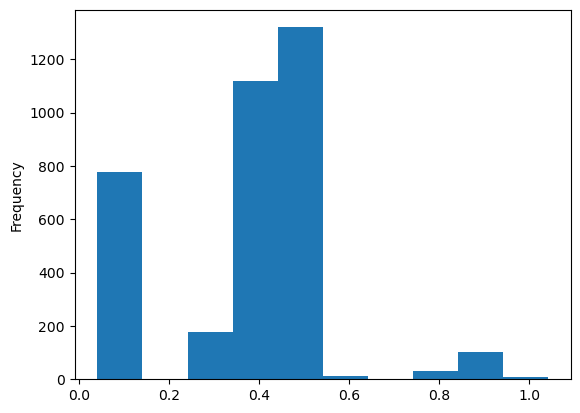

In [12]:
from src.handle_double_eclipses import remove_doubles
from src.noise_filtering import complete_filter

filtered = complete_filter(eclipses, "delta", return_diagnositics=False)
filtered['delta'].plot.hist()

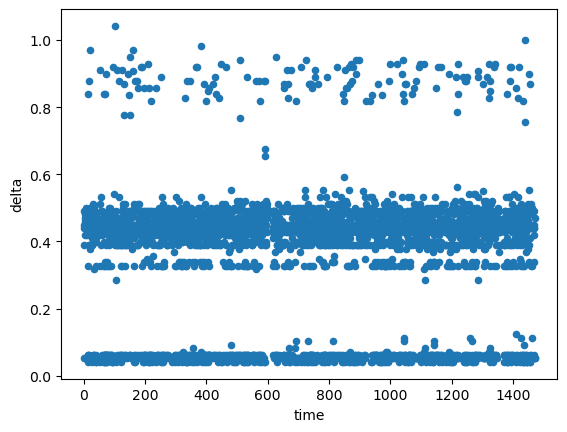

In [13]:
filtered.plot.scatter(y='delta', x='time')
plt.show()

In [14]:
period = getOC(filtered)
period

0.4532441901193981

In [15]:
period = period * round(filtered["delta"].median() / period, 0)
period  # this might break it, I hope not

0.4532441901193981

In [16]:
max(align_data(filtered["time"], period / 2) % period - period / 2)

0.22109988529988317

In [17]:
from src.noise_filtering import remove_outliers

filtered["residuals"] = align_data(filtered["time"], period / 2) % period - period / 2
filtered["residuals"]

0 eclipses dropped by outlier filter


0       0.000000
1       0.051087
2       0.102173
3       0.037187
4       0.050257
          ...   
3543   -0.088746
3544   -0.092429
3545   -0.126763
3546   -0.144345
3547   -0.093258
Name: residuals, Length: 3548, dtype: float64

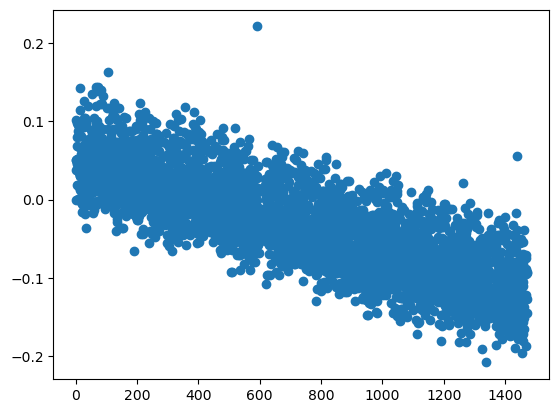

In [18]:
plt.scatter(x=filtered["time"], y=align_data(filtered["time"], period / 2) % period - period / 2)
plt.show()

In [19]:
N = 10000
k = - N // 2 + np.arange(N)
f_k = np.random.randn(N)

# non-equispaced fast Fourier transform
f = nfft.nfft(filtered["residuals"], f_k)

In [20]:
with open("data/all_systems.txt") as f:
    all_systems = f.read().split(",")

eclipses = get_eclipses(all_systems[0], "data/combined")

In [21]:
filtered, diagnostics = complete_filter(eclipses, "delta", return_diagnositics=True)